In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimpy as sk
from imblearn.over_sampling import SMOTE
import scipy.stats
from scipy.stats import f_oneway, chi2_contingency
import shap
from scipy.stats import ttest_rel, wilcoxon

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import torch
import torch.nn as nn
import skorch
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler
from skorch.callbacks import EarlyStopping, LRScheduler
from sklearn.model_selection import cross_val_score, KFold

#remove fucking warnings
import warnings
warnings.filterwarnings('ignore')
#Model Export
import joblib

In [ ]:
df = pd.read_csv("train.csv")
df

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


In [ ]:
#Descriptive Statistics
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 517754 │ │ int64       │ 4     │                                                          │
│ │ Number of columns │ 14     │ │ string      │ 4     │                                                          │
│ └───────────────────┴────────┘ │ bool        │ 4     │                                                          │
│                                │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column                 ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0 ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ id                     │   0 │     0 │  258900 │  149500 │  0 │ 129400 │ 258900 │ 388300 │ 517800 │ ██████ │  │
│ │ num_lanes              │   0 │     0 │   2.492 │    1.12 │  1 │      1 │      2 │      3 │      4 │ █ █ ██ │  │
│ │ curvature              │   0 │     0 │  0.4887 │  0.2726 │  0 │   0.26 │   0.51 │   0.71 │      1 │ ▆▆▆█▇▅ │  │
│ │ speed_limit            │   0 │     0 │   46.11 │   15.79 │ 25 │     35 │     45 │     60 │     70 │ ▇██ ▇▆ │  │
│ │ num_reported_accidents │   0 │     0 │   1.188 │   0.896 │  0 │      1 │      1 │      2 │      7 │  █▃▁   │  │
│ │ accident_risk          │   0 │     0 │  0.3524 │  0.1664 │  0 │   0.23 │   0.34 │   0.46 │      1 │ ▃██▃▁  │  │
│ └────────────────────────┴─────┴───────┴─────────┴─────────┴────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓  │
│ ┃ column                                      ┃ true             ┃ true rate               ┃ hist            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩  │
│ │ road_signs_present                          │           258465 │                     0.5 │     █    █      │  │
│ │ public_road                                 │           260045 │                     0.5 │     █    █      │  │
│ │ holiday                                     │           260688 │                     0.5 │     █    █      │  │
│ │ school_season                               │           257590 │                     0.5 │     █    █      │  │
│ └─────────────────────────────────────────────┴──────────────────┴─────────────────────────┴─────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃            ┃    ┃      ┃          ┃           ┃           ┃         ┃ chars per  ┃ words per  ┃ total      ┃  │
│ ┃ column     ┃ NA ┃ NA % ┃ shortest ┃ longest   ┃ min       ┃ max     ┃ row        ┃ row        ┃ words      ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━

In [ ]:
#Null Checking
df.isnull().sum()

,0
id,0
road_type,0
num_lanes,0
curvature,0
speed_limit,0
lighting,0
weather,0
road_signs_present,0
public_road,0
time_of_day,0


In [ ]:
#Data Preprocessing
encoder = LabelEncoder()

df["road_type"] = encoder.fit_transform(df[["road_type"]])
df["lighting"] = encoder.fit_transform(df[["lighting"]])
df["weather"] = encoder.fit_transform(df[["weather"]])
df["time_of_day"] = encoder.fit_transform(df[["time_of_day"]])

#Transforming boolean values to 0 and 1s
df["road_signs_present"] = encoder.fit_transform(df[["road_signs_present"]])
df["public_road"] = encoder.fit_transform(df[["public_road"]])
df["holiday"] = encoder.fit_transform(df[["holiday"]])
df["school_season"] = encoder.fit_transform(df[["school_season"]])

df = df.drop(columns=["id"], axis=1)

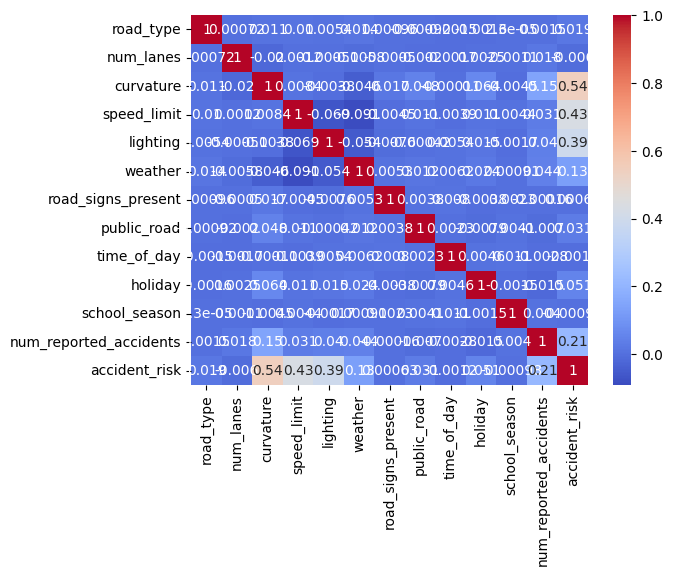

In [ ]:
#Data Visualization
#Heatmap Correlation Analyis
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
#plt.savefig("Heatmap Correlation Analyis")
plt.show()

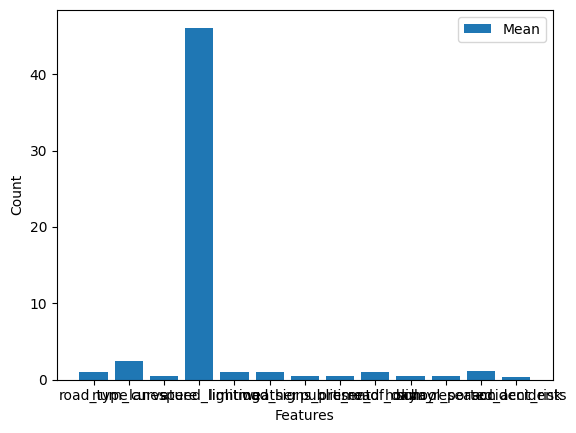

In [ ]:
#Feature Importance
features = df[["road_type", "num_lanes", "curvature", "speed_limit", "lighting", "weather", "road_signs_present", "public_road", "time_of_day", "holiday", "school_season", "num_reported_accidents", "accident_risk"]]
plt.xlabel("Features")
plt.ylabel("Count")
plt.bar(features.columns, features.mean())
plt.legend(["Mean"])
#plt.savefig("Feature Importance")
plt.show()

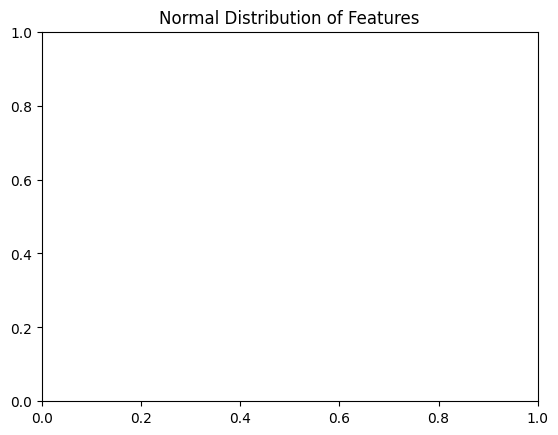

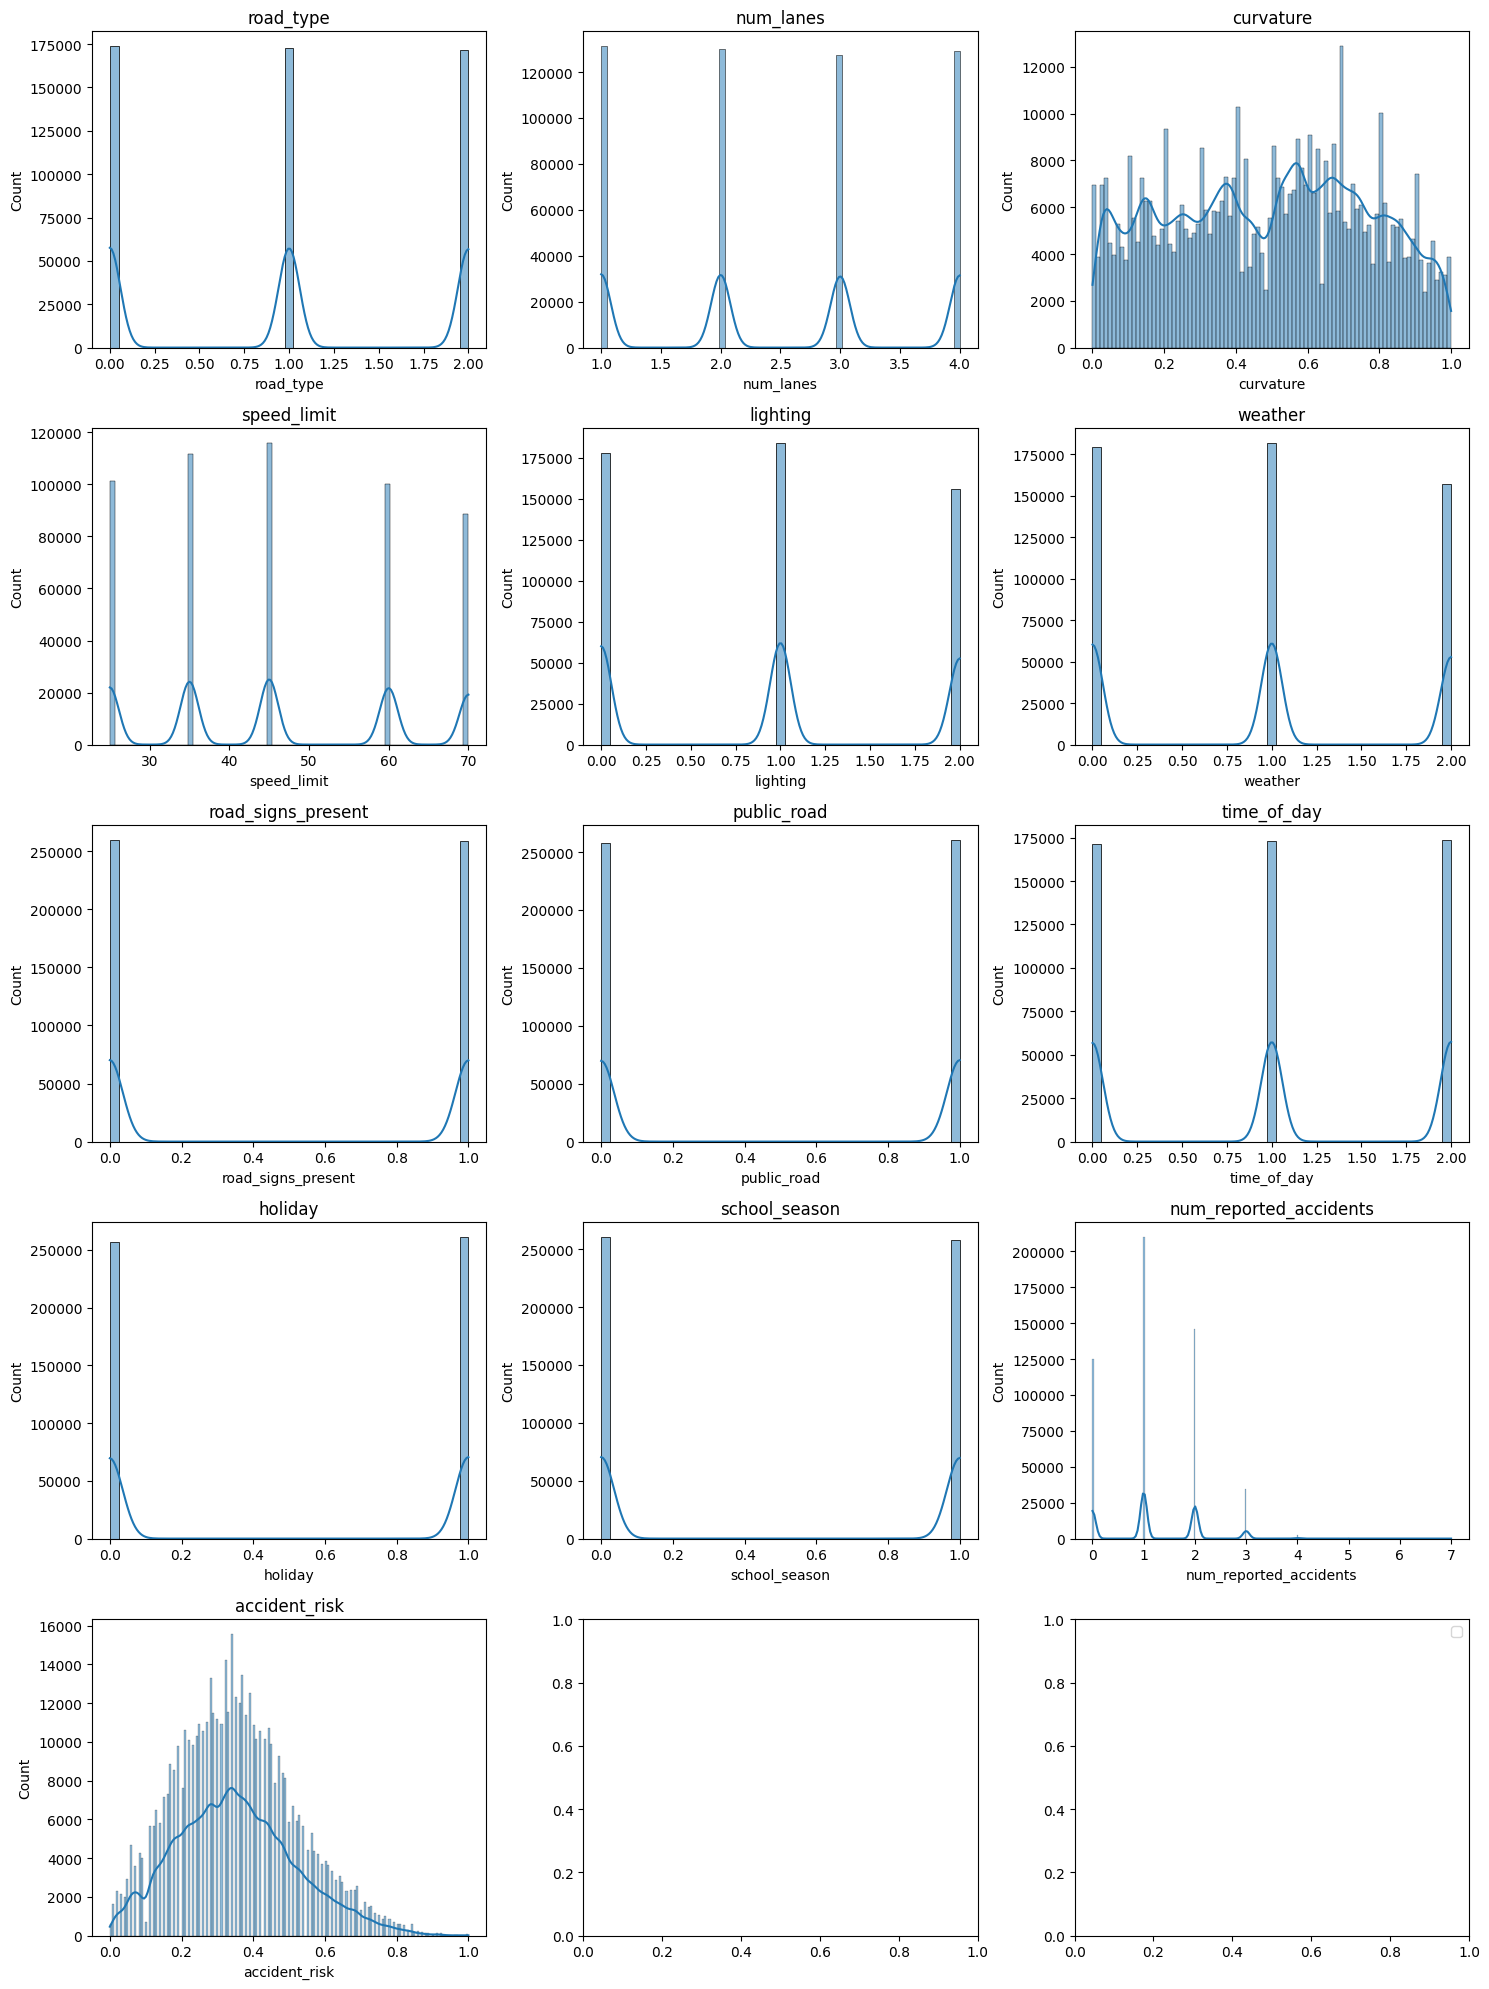

In [ ]:
#Normal Distribution
feature = ["road_type", "num_lanes", "curvature", "speed_limit", "lighting", "weather", "road_signs_present", "public_road", "time_of_day", "holiday", "school_season", "num_reported_accidents", "accident_risk"]
plt.title("Normal Distribution of Features")

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

for i, feat in enumerate(feature):
    sns.histplot(data=df, x=feat, kde=True, ax=axes[i])
    axes[i].set_title(feat)

plt.tight_layout()
#plt.savefig("Normal Distribution of Features")
plt.legend()
plt.show()

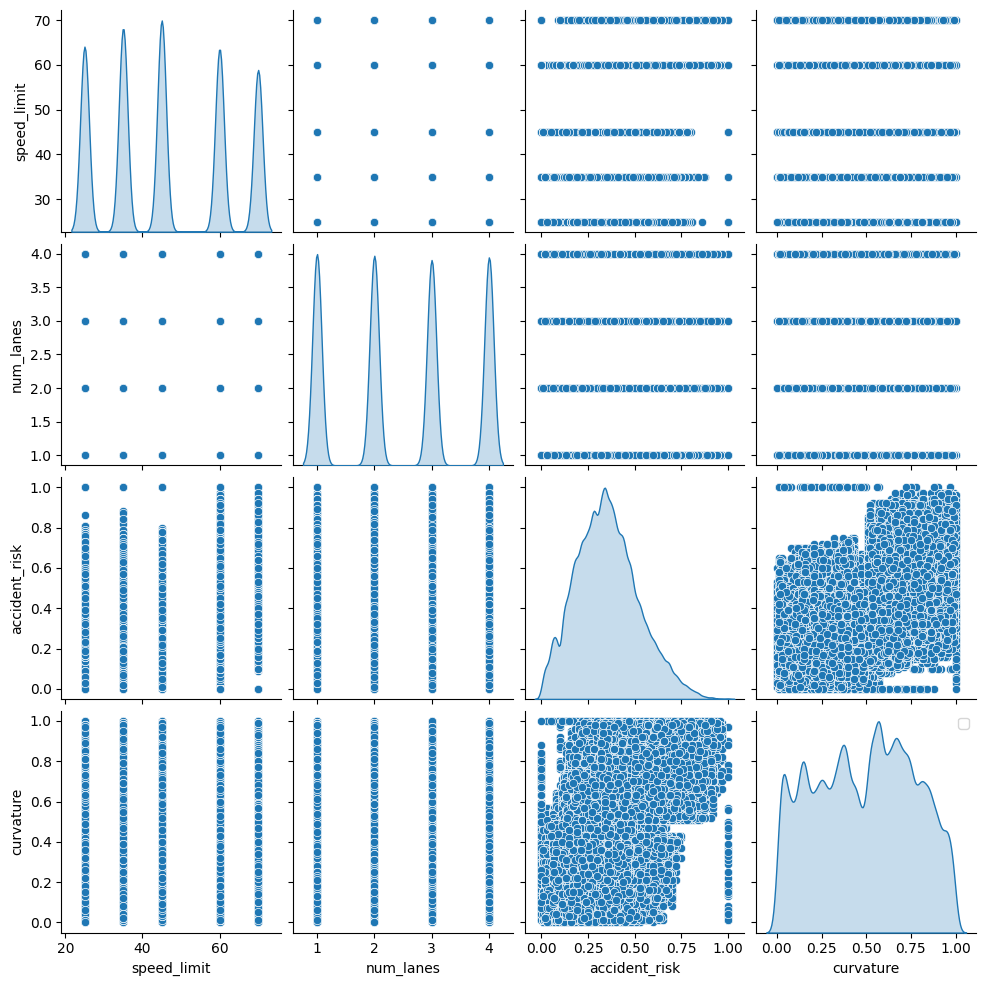

In [ ]:
#Pairwise PLotting
sns.pairplot(df[["speed_limit", "num_lanes", "accident_risk", "curvature"]], diag_kind="kde")
plt.legend()
#plt.savefig("Pairwise Plot")
plt.show()

In [ ]:
#Feature Engineering
df["num_reported_accidents_log"] = np.log1p(df["num_reported_accidents"])
df["traffic_density"] = df["num_lanes"] / df["speed_limit"]
df["curvature_intenisty"] = df["curvature"] * df["speed_limit"]
df["risk_exposure"] = df["num_reported_accidents"] / df["num_lanes"]
df["congestion_risk"] = np.where((df["holiday"] == 0) & (df["school_season"] == 1), 1, 0)
df["mean_accidents"] = df.groupby("road_type")["num_reported_accidents"].transform("mean")
df["mean_accidents_deviation"] = df["num_reported_accidents"] - df["mean_accidents"]
df

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,num_reported_accidents_log,traffic_density,curvature_intenisty,risk_exposure,congestion_risk,mean_accidents,mean_accidents_deviation
0,2,2,0.06,35,0,2,0,1,0,0,1,1,0.13,0.693147,0.057143,2.10,0.50,1,1.192632,-0.192632
1,2,4,0.99,35,0,0,1,0,1,1,1,0,0.35,0.000000,0.114286,34.65,0.00,0,1.192632,-1.192632
2,1,4,0.63,70,1,0,0,1,2,1,0,2,0.30,1.098612,0.057143,44.10,0.50,0,1.182105,0.817895
3,0,4,0.07,35,1,2,1,1,2,0,0,1,0.21,0.693147,0.114286,2.45,0.25,0,1.189201,-0.189201
4,1,1,0.58,60,0,1,0,0,1,1,0,1,0.56,0.693147,0.016667,34.80,1.00,0,1.182105,-0.182105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,0,4,0.10,70,0,1,1,1,0,0,0,2,0.32,1.098612,0.057143,7.00,0.50,0,1.189201,0.810799
517750,1,4,0.47,35,0,2,1,1,2,0,0,1,0.26,0.693147,0.114286,16.45,0.25,0,1.182105,-0.182105
517751,2,4,0.62,25,0,1,0,0,0,0,1,0,0.19,0.000000,0.160000,15.50,0.00,1,1.192632,-1.192632
517752,0,3,0.63,25,2,0,1,0,0,1,1,3,0.51,1.386294,0.120000,15.75,1.00,0,1.189201,1.810799


In [ ]:
df.isnull().sum()

,0
road_type,0
num_lanes,0
curvature,0
speed_limit,0
lighting,0
weather,0
road_signs_present,0
public_road,0
time_of_day,0
holiday,0


In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, X):
        return self.model(X)

In [ ]:
X = df.drop(columns=["accident_risk"], axis=1)
y = df["accident_risk"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
OPTIMIZERS = {
    'adam': torch.optim.Adam,
    'adamw': torch.optim.AdamW
}

In [ ]:
nn_model = NeuralNetRegressor(
    module=NeuralNet,
    module__input_dim=X_train.shape[1],
    max_epochs=30,
    lr=0.001,
    optimizer=torch.optim.Adam,
)

In [ ]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", nn_model)
])

In [ ]:
param_grid = {
    "model__lr": [1e-2, 1e-3, 3e-4],
    "model__module__hidden_dim": [64, 128, 256],
    "model__module__num_layers": [2, 3, 4],
    "model__module__dropout": [0.1, 0.2, 0.3],
    "model__batch_size": [32, 64, 128]
}

In [ ]:
X_train.shape

(414203, 19)

In [ ]:
#Too much Dimensionality, so we gotta reduce it
y_scaler = StandardScaler()
Y_train_scaled = y_scaler.fit_transform(Y_train.values.reshape(-1, 1)).ravel()
Y_test_scaled = y_scaler.transform(Y_test.values.reshape(-1, 1)).ravel()

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", nn_model)
])

In [ ]:
pipe.fit(X_train.astype('float32'), Y_train_scaled.astype('float32'))

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.0059        0.9970  11.9043
      2        1.0015        0.9967  11.7895
      3        1.0009        0.9966  11.8725
      4        1.0009        0.9966  11.7822
      5        1.0007        0.9967  11.5538
      6        1.0005        0.9967  11.7125
      7        1.0003        0.9967  11.7318
      8        0.9999        0.9967  11.7368
      9        0.9996        0.9967  11.9278
     10        0.9994        0.9967  11.9529
     11        0.9993        0.9968  12.9802
     12        0.9992        0.9967  12.0240
     13        0.9991        0.9968  12.0141
     14        0.9990        0.9968  12.0514
     15        0.9989        0.9969  12.0819
     16        0.9988        0.9968  12.2135
     17        0.9987        0.9968  12.1541
     18        0.9986        0.9968  12.1116
     19        0.9985        0.9968  12.1104
     20        0.9984        0.9969  12.1303
     21   

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 NeuralNetRegressor(_params_to_validate={'module__input_dim'}, batch_size=128, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cpu', iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_valid=<class 'torch.utils.data.dataloader.DataLoader'>, lr=0.001, max_epochs=30, module=<class '__main__.NeuralNet'>, module__input_dim=19, optimizer=<class 'torch.optim.adam.Adam'>, predict_nonlinearity='auto', torch_load_kwargs=None, train_split=<skorch.dataset.ValidSplit object at 0x794fe8137a10>, use_caching='auto', verbose=1, warm_start=False))])

In [ ]:
y_pred = y_scaler.inverse_transform(pipe.predict(X_test.astype('float32')).reshape(-1, 1))

In [ ]:
mse_nn = mean_squared_error(Y_test_scaled, y_pred)
mae_nn = mean_absolute_error(Y_test_scaled, y_pred)
r2_nn = r2_score(Y_test_scaled, y_pred)

print(f"NeuralNetRegressor Results:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R²:  {r2_nn:.4f}")

"""
This SHIT is Not WORKING
"""

NeuralNetRegressor Results:
MSE: 1.1211
MAE: 0.8645
R²:  -0.1253


'\nThis SHIT is Not WORKING\n'

In [ ]:
#Machine Learning Model (MY best Picks And Alternatives)
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

model_1 = CatBoostRegressor(
    iterations=2000,          # Longer training helps smooth out boosting
    learning_rate=0.03,       # Small learning rate improves generalization
    depth=8,                  # Deeper trees for complex relationships
    l2_leaf_reg=3,            # L2 regularization (default = 3)
    loss_function='RMSE',
    random_seed=42,
    bagging_temperature=0.8,  # Adds randomness for generalization
    od_type='Iter',           # Early stopping
    od_wait=50,
    verbose=200
)
model_2 = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,        # L2 regularization
    reg_alpha=0.5,         # L1 regularization
    gamma=0.2,             # Minimum loss reduction
    min_child_weight=3,    # Prevents overfitting on small leaves
    random_state=42,
    tree_method='hist',    # GPU if available: 'gpu_hist'
    eval_metric='rmse'
)
model_3 = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=-1,              # Let model decide
    num_leaves=64,             # 2^(depth) / 2
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    min_child_samples=30,
    random_state=42,
    boosting_type='gbdt',
    objective='regression',
    verbose=-1
)
for name, model in {
    "CatBoost": model_1,
    "XGBoost": model_2,
    "LightGBM": model_3
}.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} Results:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}\n RMSE: {rmse:.4f}")

0:	learn: 0.1621387	total: 156ms	remaining: 5m 11s
200:	learn: 0.0563301	total: 24.3s	remaining: 3m 37s
400:	learn: 0.0560558	total: 40.9s	remaining: 2m 42s
600:	learn: 0.0558615	total: 57.5s	remaining: 2m 13s
800:	learn: 0.0557054	total: 1m 26s	remaining: 2m 9s
1000:	learn: 0.0555677	total: 1m 44s	remaining: 1m 44s
1200:	learn: 0.0554375	total: 2m 1s	remaining: 1m 20s
1400:	learn: 0.0553164	total: 2m 19s	remaining: 59.7s
1600:	learn: 0.0551988	total: 2m 36s	remaining: 39s
1800:	learn: 0.0550931	total: 2m 53s	remaining: 19.2s
1999:	learn: 0.0549879	total: 3m 11s	remaining: 0us
CatBoost Results:
MSE: 0.0032, MAE: 0.0437, R²: 0.8854
 RMSE: 0.0563
XGBoost Results:
MSE: 0.0032, MAE: 0.0439, R²: 0.8842
 RMSE: 0.0565
LightGBM Results:
MSE: 0.0032, MAE: 0.0436, R²: 0.8854
 RMSE: 0.0563


In [ ]:
y_pred_cat = model_1.predict(X_test)
y_pred_xgb = model_2.predict(X_test)
y_pred_lgb = model_3.predict(X_test)

# Weighted ensemble (CatBoost slightly favored)
y_pred_ensemble = (0.4*y_pred_cat + 0.3*y_pred_xgb + 0.3*y_pred_lgb)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(Y_test, y_pred_ensemble)
mae = mean_absolute_error(Y_test, y_pred_ensemble)
r2 = r2_score(Y_test, y_pred_ensemble)
print(f"Ensemble Results:\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, RMSE: {np.sqrt(mse):.4f}")

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in {
    "CatBoost": model_1,
    "XGBoost": model_2,
    "LightGBM": model_3
}.items():
    scores = cross_val_score(model, X_train, Y_train,
                             cv=kf, scoring='r2', n_jobs=-1)
    print(f"{name} CV R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

CatBoost CV R²: 0.8864 ± 0.0013
XGBoost CV R²: 0.8853 ± 0.0013
LightGBM CV R²: 0.8865 ± 0.0012


In [ ]:
#Testing for wilcoxon test and t-testing
preds_cat = model_1.predict(X_test)
preds_xgb = model_2.predict(X_test)
preds_lgb = model_3.predict(X_test)

# Clean and align
preds_cat = np.nan_to_num(preds_cat)
preds_xgb = np.nan_to_num(preds_xgb)
preds_lgb = np.nan_to_num(preds_lgb)

# Compute errors per sample (e.g., absolute error)
errors_cat = np.abs(Y_test - preds_cat)
errors_xgb = np.abs(Y_test - preds_xgb)
errors_lgb = np.abs(Y_test - preds_lgb)

# --- Paired t-tests (parametric) ---
t_stat_cat_lgb, p_cat_lgb = ttest_rel(errors_cat, errors_lgb)
t_stat_cat_xgb, p_cat_xgb = ttest_rel(errors_cat, errors_xgb)
t_stat_xgb_lgb, p_xgb_lgb = ttest_rel(errors_xgb, errors_lgb)

# --- Wilcoxon signed-rank tests (non-parametric) ---
try:
    w_stat_cat_lgb, p_wil_cat_lgb = wilcoxon(errors_cat, errors_lgb)
except ValueError:
    p_wil_cat_lgb = np.nan  # identical predictions

try:
    w_stat_cat_xgb, p_wil_cat_xgb = wilcoxon(errors_cat, errors_xgb)
except ValueError:
    p_wil_cat_xgb = np.nan

try:
    w_stat_xgb_lgb, p_wil_xgb_lgb = wilcoxon(errors_xgb, errors_lgb)
except ValueError:
    p_wil_xgb_lgb = np.nan

print("CatBoost vs LGBM → t-test p =", p_cat_lgb, ", Wilcoxon p =", p_wil_cat_lgb)
print("CatBoost vs XGB  → t-test p =", p_cat_xgb, ", Wilcoxon p =", p_wil_cat_xgb)
print("XGB vs LGBM      → t-test p =", p_xgb_lgb, ", Wilcoxon p =", p_wil_xgb_lgb)

CatBoost vs LGBM → t-test p = 0.01546921263377085 , Wilcoxon p = 0.0021490084657548093
CatBoost vs XGB  → t-test p = 1.8690811834415184e-32 , Wilcoxon p = 1.1451294371992274e-24
XGB vs LGBM      → t-test p = 1.9375985194314248e-42 , Wilcoxon p = 2.640008935595148e-32


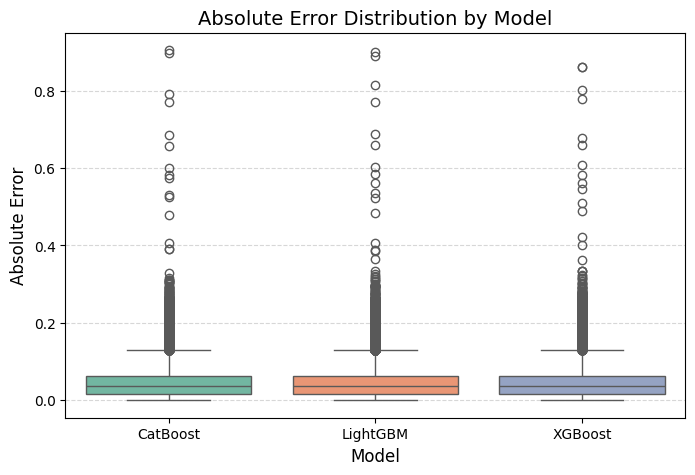

In [ ]:
#Visualizing Errors
errors_df = pd.DataFrame({
    'CatBoost': np.abs(Y_test - preds_cat),
    'LightGBM': np.abs(Y_test - preds_lgb),
    'XGBoost': np.abs(Y_test - preds_xgb),
})

plt.figure(figsize=(8,5))
sns.boxplot(data=errors_df, palette="Set2")
plt.title("Absolute Error Distribution by Model", fontsize=14)
plt.ylabel("Absolute Error", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig("Absolute Error Distribution by Model")
plt.show()


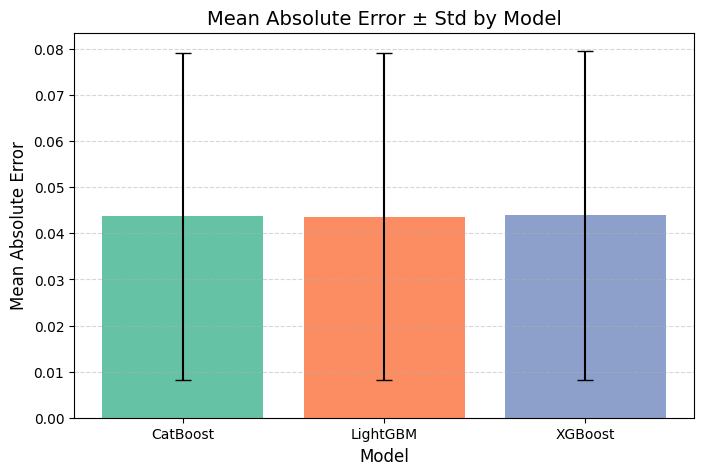

In [ ]:
models = mean_errors.index
means = mean_errors.values
stds = std_errors.values

plt.figure(figsize=(8,5))
plt.bar(models, means, yerr=stds, capsize=6, color=['#66c2a5','#fc8d62','#8da0cb'])
plt.title("Mean Absolute Error ± Std by Model", fontsize=14)
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig("Mean Absolute Error STD by Model")
plt.show()

## We picked CatBoost for Regression Predicton of Accident Risk

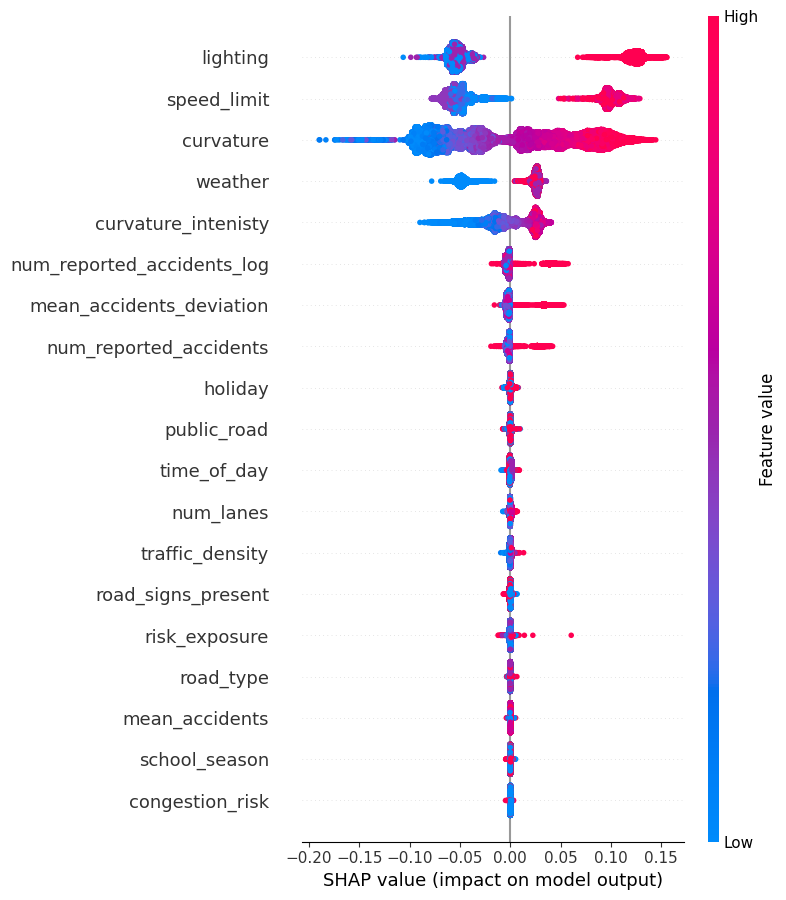

<Figure size 640x480 with 0 Axes>

In [23]:
explainer_cat = shap.TreeExplainer(model_1)
shap_values_cat = explainer_cat.shap_values(X_test)
shap.summary_plot(shap_values_cat, X_test, plot_type="dot", show=True)
#plt.savefig("Summary Plot of SHAP Visualization")

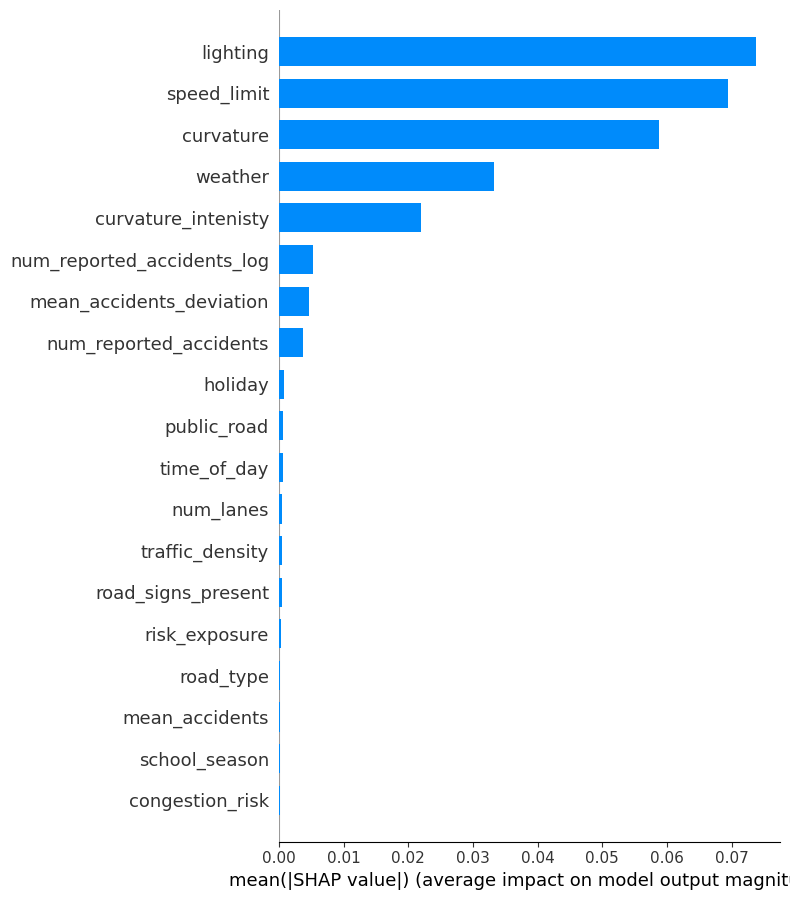

<Figure size 640x480 with 0 Axes>

In [24]:
shap.summary_plot(shap_values_cat, X_test, plot_type="bar", show=True)
plt.savefig("Ranked Feature Importance of The model")

## Stress Testing For The Best Model Before Test Set Predictions

In [25]:
def add_noise(X, noise_level=0.05):
    X_noisy = X.copy()
    num_cols = X.select_dtypes(include=np.number).columns
    for col in num_cols:
        X_noisy[col] += np.random.normal(0, noise_level * X[col].std(), X[col].shape)
    return X_noisy

X_test_noisy = add_noise(X_test, noise_level=0.1)
pred_noisy = model_1.predict(X_test_noisy)

print("Δ (CatBoost) Noise Impact (MAE diff):",
      np.abs(pred_noisy - model_1.predict(X_test)).mean())

Δ (CatBoost) Noise Impact (MAE diff): 0.008036109905964869


In [26]:
def introduce_missing(X, frac=0.05):
    X_miss = X.copy()
    for col in X.columns:
        mask = np.random.rand(len(X)) < frac
        X_miss.loc[mask, col] = np.nan
    return X_miss

X_test_missing = introduce_missing(X_test, frac=0.1)
pred_missing = model_1.predict(X_test_missing.fillna(X_test.mean()))

print("Δ (CatBoost) Missing Impact (MAE diff):",
      np.abs(pred_missing - model_1.predict(X_test)).mean())

Δ (CatBoost) Missing Impact (MAE diff): 0.025503073561658644


In [27]:
def subgroup_stress_test(df, model, feature, thresholds):
    results = {}
    for low, high in thresholds:
        subset = df[(df[feature] >= low) & (df[feature] < high)]
        if len(subset) > 10:
            preds = model.predict(subset)
            results[f"{low}-{high}"] = np.mean(preds)
    return results

speed_segments = subgroup_stress_test(X_test, model_1, "speed_limit",
                                      [(0,40),(40,80),(80,120)])
print("CatBoost Mean Prediction by Speed Segment:", speed_segments)

CatBoost Mean Prediction by Speed Segment: {'0-40': np.float64(0.2895330221923687), '40-80': np.float64(0.3949449290791091)}


## Now, We make the the test predictions and submit to kaggle

In [29]:
test_df = pd.read_csv("test.csv")
test_df

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172580,690334,rural,2,0.01,45,dim,rainy,False,False,afternoon,True,True,2
172581,690335,rural,1,0.74,70,daylight,foggy,False,True,afternoon,False,False,2
172582,690336,urban,2,0.14,70,dim,clear,False,False,evening,True,True,1
172583,690337,urban,1,0.09,45,daylight,foggy,True,True,morning,False,True,0


In [31]:
categorical_cols = ["road_type", "lighting", "weather", "time_of_day"]

for col in categorical_cols:
    le = LabelEncoder()
    test_df[col] = test_df[col].astype(str)  # Ensure string type
    test_df[col] = le.fit_transform(test_df[col])


#Binary Tagging
binary_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in binary_cols:
    test_df[col] = test_df[col].astype(int)

#Data Preprocessing
numeric_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
test_df[numeric_cols] = test_df[numeric_cols].fillna(test_df[numeric_cols].median())

In [32]:
from feature_engineer import feature_engineer
test_fe = feature_engineer(test_df)

In [33]:
feature_cols = [
    'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather',
    'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season',
    'num_reported_accidents', 'num_reported_accidents_log', 'traffic_density',
    'curvature_intenisty', 'risk_exposure', 'congestion_risk',
    'mean_accidents', 'mean_accidents_deviation'
]

X_test_final = test_fe[feature_cols]

In [35]:
#final model pipeline
pipeline_final = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_1)
])

pipeline_final.fit(X_train, Y_train)

0:	learn: 0.1621387	total: 136ms	remaining: 4m 32s
200:	learn: 0.0563301	total: 17.5s	remaining: 2m 36s
400:	learn: 0.0560558	total: 35.5s	remaining: 2m 21s
600:	learn: 0.0558615	total: 52.3s	remaining: 2m 1s
800:	learn: 0.0557054	total: 1m 10s	remaining: 1m 45s
1000:	learn: 0.0555677	total: 1m 27s	remaining: 1m 27s
1200:	learn: 0.0554375	total: 1m 44s	remaining: 1m 9s
1400:	learn: 0.0553164	total: 2m 2s	remaining: 52.5s
1600:	learn: 0.0551988	total: 2m 20s	remaining: 34.9s
1800:	learn: 0.0550931	total: 2m 37s	remaining: 17.4s
1999:	learn: 0.0549890	total: 2m 55s	remaining: 0us


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7df100f56270>)])

In [36]:
y_pred_final = model.predict(X_test_final)

submission = pd.DataFrame({
    "id": test_df["id"],
    "accident_risk": y_pred_final
})

In [37]:
submission.to_csv("submission.csv", index=False)
#NOW. We are FUCKING FINISHED.

In [39]:
with open("CatBoostModel.pkl", "wb+") as model:
  joblib.dump(pipeline_final, model)